In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-04-24 20:06:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-04-24 20:06:25 (90.8 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length = max_sequence_len - 1))
model.add(Bidirectional(LSTM(150, return_sequences= True)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(total_words / 2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))
# Pick an optimizer
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =  ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 1605)              104325    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 5,976,931
Trainable params: 5,976,931
Non-trainable params: 0
______________________________________________

In [5]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 45s 25ms/step - loss: 7.2254 - accuracy: 0.0207
Epoch 2/100
484/484 [==============================] - 12s 25ms/step - loss: 6.4848 - accuracy: 0.0214
Epoch 3/100
484/484 [==============================] - 12s 25ms/step - loss: 6.3916 - accuracy: 0.0243
Epoch 4/100
484/484 [==============================] - 12s 25ms/step - loss: 6.2905 - accuracy: 0.0285
Epoch 5/100
484/484 [==============================] - 12s 25ms/step - loss: 6.2047 - accuracy: 0.0344
Epoch 6/100
484/484 [==============================] - 12s 25ms/step - loss: 6.1810 - accuracy: 0.0339
Epoch 7/100
484/484 [==============================] - 12s 25ms/step - loss: 6.1032 - accuracy: 0.0412
Epoch 8/100
484/484 [==============================] - 12s 25ms/step - loss: 6.0338 - accuracy: 0.0420
Epoch 9/100
484/484 [==============================] - 12s 25ms/step - loss: 5.9773 - accuracy: 0.0457
Epoch 10/100
484/484 [==============================] - 12s 25ms/step - l

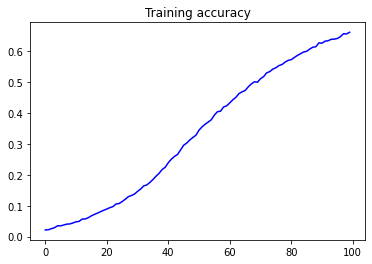

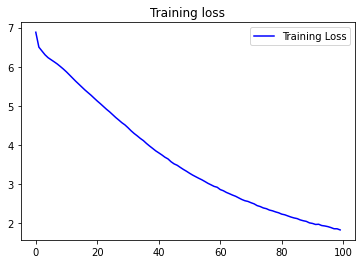

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [7]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope when you compile light taken new date clearer light increase bright days affords hence which you grow perjured blot to this sort alone aside find thine eye so beloved of me more friend acquainted aside so last her worth so old much spacious doth adieu warm'd fangled pride stay another thee aside room so common lie of thine that thy mind most verse back afloat light light bright end goodly pride sheds bow survey hold so earth by infection devise a tomb so colour or bright quite knights fitted look are hell still loss alone now his praise shall weeks
